In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn

from time import perf_counter

import os, sys
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
device = "cpu"

In [2]:
import model.quantization.imagenet.binput_prerprelu_reactnet_pg_test as m
net = m.ReActNet(batch_size=1, num_gpus=torch.cuda.device_count())

* ReActNet with preact RPReLU.
* Precision gated activations.
* Binary input layer!


In [3]:
# _ARCH = 'binput-prerprelu-pg-test'

n_param = sum(p.numel() for p in net.parameters() if p.requires_grad)
print("Number of parameters: {}\n".format(n_param))

resume = 'pretrained_imagenet_dont_push/binput_prerprelu_pg.pt'
loaded_dict = torch.load(resume)

# for k, v in net.state_dict().items():
#     print(k)
    
from collections import OrderedDict
new_dict = OrderedDict()
for k, v in loaded_dict.items():
    name = k[7:]
#     print(k)
    new_dict[name] = v
# new_dict['encoder.placeholder'] = loaded_dict['encoder.placeholder'][0:1, :, :, :, :]
net.load_state_dict(new_dict, strict=False)
# net.to(device)


Number of parameters: 29393192



_IncompatibleKeys(missing_keys=['encoder.placeholder', 'teacher.conv1.weight', 'teacher.bn1.weight', 'teacher.bn1.bias', 'teacher.bn1.running_mean', 'teacher.bn1.running_var', 'teacher.layer1.0.conv1.weight', 'teacher.layer1.0.bn1.weight', 'teacher.layer1.0.bn1.bias', 'teacher.layer1.0.bn1.running_mean', 'teacher.layer1.0.bn1.running_var', 'teacher.layer1.0.conv2.weight', 'teacher.layer1.0.bn2.weight', 'teacher.layer1.0.bn2.bias', 'teacher.layer1.0.bn2.running_mean', 'teacher.layer1.0.bn2.running_var', 'teacher.layer1.0.conv3.weight', 'teacher.layer1.0.bn3.weight', 'teacher.layer1.0.bn3.bias', 'teacher.layer1.0.bn3.running_mean', 'teacher.layer1.0.bn3.running_var', 'teacher.layer1.0.downsample.0.weight', 'teacher.layer1.0.downsample.1.weight', 'teacher.layer1.0.downsample.1.bias', 'teacher.layer1.0.downsample.1.running_mean', 'teacher.layer1.0.downsample.1.running_var', 'teacher.layer1.1.conv1.weight', 'teacher.layer1.1.bn1.weight', 'teacher.layer1.1.bn1.bias', 'teacher.layer1.1.bn1.ru

In [4]:
from PIL import Image
import numpy as np

data_dir = '../../ILSVRC2012/ImageNet'
batch_size = 10

traindir = os.path.join(data_dir, 'train')
valdir = os.path.join(data_dir, 'val')
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
crop_scale = 0.08
lighting_param = 0.1
# train_transforms = transforms.Compose([
#             transforms.Resize(256),
#             transforms.CenterCrop(224),
#             transforms.ToTensor(),
#             normalize,
#         ])
train_transforms = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor()
        ])

ts = perf_counter()
trainloader = torch.utils.data.DataLoader(
    torchvision.datasets.ImageFolder(traindir, transform=train_transforms), 
    batch_size=batch_size, shuffle=False,
    num_workers=max(8, 2*torch.cuda.device_count()), 
    pin_memory=True, drop_last=True
)
tt = perf_counter()
print('Load train takes %.2f seconds'%(tt - ts))

ts = perf_counter()
testloader = torch.utils.data.DataLoader(
    torchvision.datasets.ImageFolder(valdir, transform=train_transforms),
    batch_size=batch_size, shuffle=False,
    num_workers=max(8, 2*torch.cuda.device_count()), 
    pin_memory=True, drop_last=True
)
tt = perf_counter()
print('Load test takes %.2f seconds'%(tt - ts))

Load train takes 6.83 seconds
Load test takes 1.17 seconds


In [5]:
##############################################################
######### THIS IS IN TRAINING SCRIPT #########################
##############################################################
# normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                  std=[0.229, 0.224, 0.225])
# crop_scale = 0.08
# lighting_param = 0.1
# train_transforms = transforms.Compose([
#     transforms.RandomResizedCrop(224, scale=(crop_scale, 1.0)),
#     util.Lighting(lighting_param),
#     transforms.RandomHorizontalFlip(),
#     transforms.ToTensor(),
#     normalize,
# ])

# train_dataset = torchvision.datasets.ImageFolder(
#     traindir,
#     transform=train_transforms
# )

# trainloader = torch.utils.data.DataLoader(
#     train_dataset, batch_size=batch_size, shuffle=True,
#     num_workers=max(8, 2*torch.cuda.device_count()), 
#     pin_memory=True, drop_last=drop_last
# )

# valloader = torch.utils.data.DataLoader(
#     torchvision.datasets.ImageFolder(valdir, transforms.Compose([
#         transforms.Resize(256),
#         transforms.CenterCrop(224),
#         transforms.ToTensor(),
#         normalize,
#     ])),
#     batch_size=batch_size, shuffle=False,
#     num_workers=max(8, 2*torch.cuda.device_count()), 
#     pin_memory=True, drop_last=drop_last
# )

In [6]:
dataiter = iter(trainloader)

In [7]:
data = dataiter.next()
print(data[0].shape)
print(data[1].shape)

torch.Size([10, 3, 224, 224])
torch.Size([10])


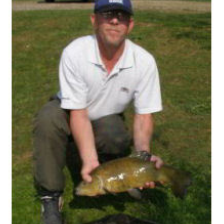

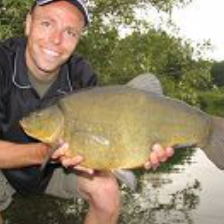

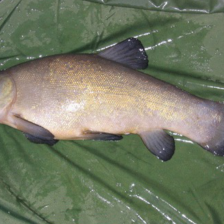

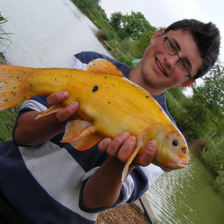

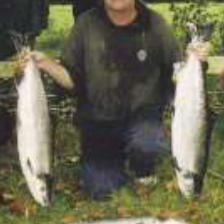

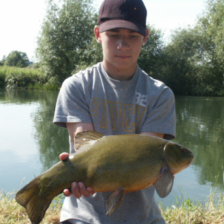

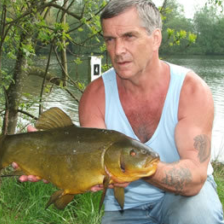

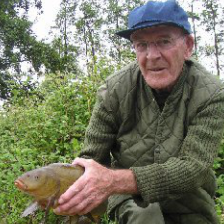

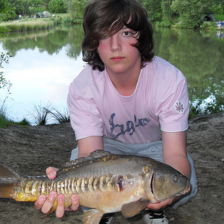

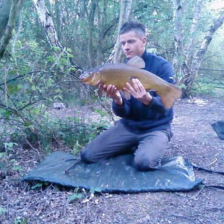

In [8]:
for i in range(batch_size):
    img = data[0][i]
#     print(img)
#     print(img.shape)
    img = img.cpu().numpy()*255.0
    display(Image.fromarray(img.transpose(1, 2, 0).astype(np.uint8)))
#     print(np.amin(img))
#     print(np.amax(img))

In [9]:
net.to(device)

# switch the model to the evaluation mode
net.eval()

# data = dataiter.next()

ts = perf_counter()
with torch.no_grad():

    outputs,_ = net(data[0])
#     print(outputs)

    _, predicted = outputs.topk(1, 1, True, True)
    predicted = predicted.t()
tt = perf_counter()

net_input
torch.Size([10, 3, 224, 224])
tensor([[[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],

         [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],

         [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
  

torch.float32
encoder
torch.Size([10, 96, 224, 224])
tensor([[[[ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
          [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
          [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
          ...,
          [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
          [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
          [ 1.,  1.,  1.,  ...,  1.,  1.,  1.]],

         [[ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
          [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
          [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
          ...,
          [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
          [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
          [ 1.,  1.,  1.,  ...,  1.,  1.,  1.]],

         [[ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
          [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
          [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
          ...,
          [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
          [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
          [ 1.,  1.,  1.,  ...,  1.,  1.,  1.]],

         ...,

         [[-1., -